# Series de Tiempo
## Shampoo data set

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


## Preparación

In [ ]:
#Obtención de los df
df = pd.read_csv('./shampoo.csv')

# Asumiendo que el primer año es 2001
start_year = 2001
# Convertimos "1-01" a "2001-01", "2-05" a "2002-05", etc.
df['ParsedMonth'] = df['Month'].apply(lambda x: f"{start_year + int(x.split('-')[0]) - 1}-{x.split('-')[1]}")

# Parseamos a datetime
df['ParsedMonth'] = pd.to_datetime(df['ParsedMonth'], format='%Y-%m')

# Separación de los df train/test
train_size = int(len(df) * 0.7)
train_data = df[0:train_size]
test_data = df[train_size:len(df)]

## Análisis exploratorio

In [22]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Reporte EDA", explorative=True)
profile.to_file("reporte.html")


ModuleNotFoundError: No module named 'ydata_profiling'

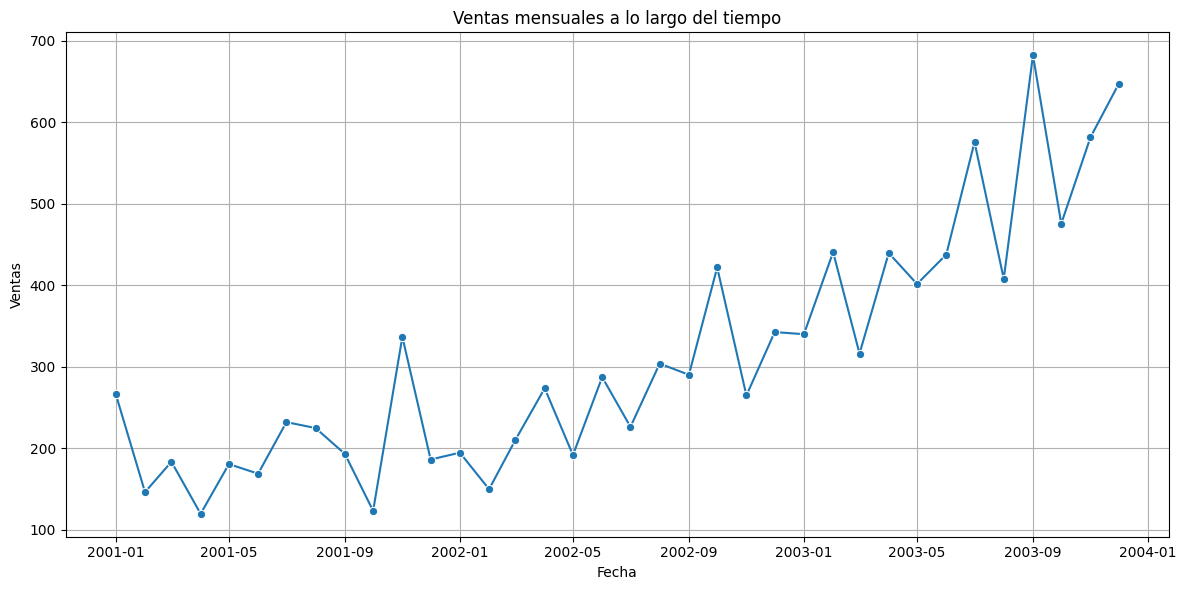

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='ParsedMonth', y='Sales', marker='o')
plt.title('Ventas mensuales a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.grid(True)
plt.tight_layout()
plt.show()

Se observan ciclos anuales claros (patrón estacional).

Hay un aumento progresivo en las ventas con el tiempo lo que es indicio de una tendencia creciente.

Algunos picos muy pronunciados podrían indicar meses especiales o campañas.

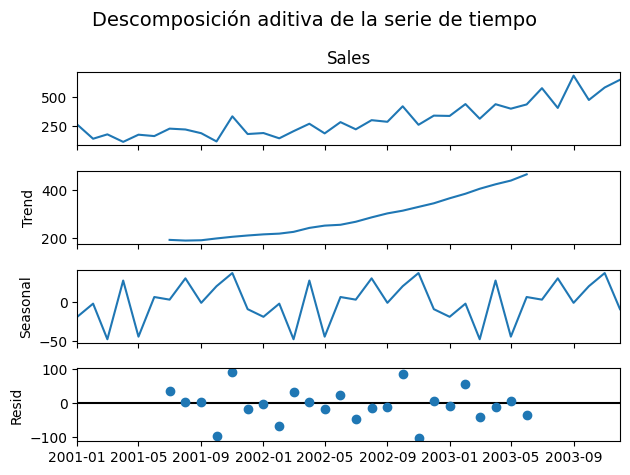

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Usar la columna con fecha como índice
df_ts = df.set_index('ParsedMonth')

# Descomposición aditiva
result = seasonal_decompose(df_ts['Sales'], model='additive', period=12)

# Graficar la descomposición
result.plot()
plt.suptitle('Descomposición aditiva de la serie de tiempo', fontsize=14)
plt.tight_layout()
plt.show()

- Tendencia: Línea suave que muestra crecimiento continuo.
- Estacionalidad: Repetición de picos o valles según el mes.
- Ruido (residual): Variación aleatoria que no se explica por tendencia o estacionalidad.

## Algoritmos de Series de Tiempo

### Promedios Móviles

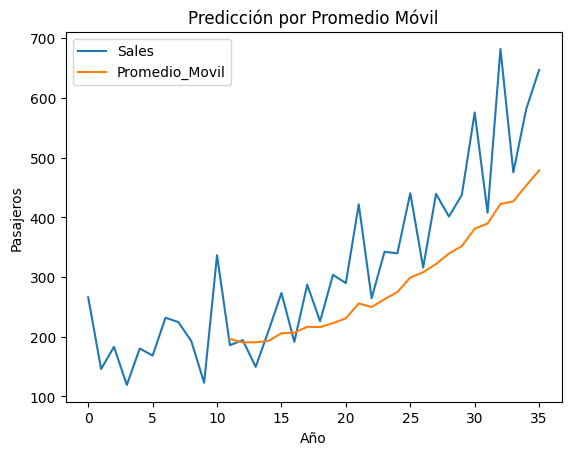

In [17]:
# Promedio Móvil
df['Promedio_Movil'] = df['Sales'].rolling(window = 12).mean()

# Graficar los df y el Promedio Móvil
df[['Sales', 'Promedio_Movil']].plot()
plt.title("Predicción por Promedio Móvil")
plt.xlabel("Año")
plt.ylabel("Pasajeros")
plt.show()

### Aislamiento exponencial

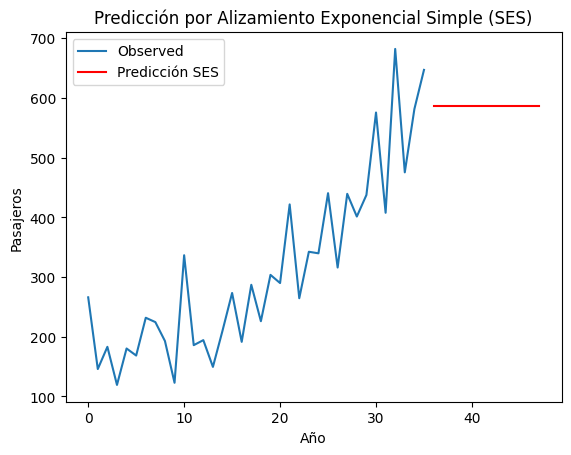

In [18]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Alizamiento Exponencial Simple

modelo = SimpleExpSmoothing(df['Sales'])

# Ajustar (entrenar() el modelo

modelo_ajustado = modelo.fit()
prediccion = modelo_ajustado.forecast(12)

# Graficar los df y las predicciones

df['Sales'].plot(label = 'Observed')
prediccion.plot(label = 'Predicción SES', color = 'red')
plt.legend()
plt.title("Predicción por Alizamiento Exponencial Simple (SES)")
plt.xlabel("Año")
plt.ylabel("Pasajeros")
plt.show()

### HOLT-WINTERS

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Modelo Estacional de Holt_winters

modelo = ExponentialSmoothing(df['Sales'], seasonal = 'mul', seasonal_periodf = 12)

# Ajustar (entrenar) el modelo

modelo_ajustado = modelo.fit()
predicciones = modelo_ajustado.forecast(12)

# Graficar los df y predicciones

df['Sales'].plot(label = 'Observados')
predicciones.plot(label = 'Predicciones Holt-Winters', color = 'red')
plt.legend()
plt.title("Modelo Holt-Winters de Predicciones Estacionales")
plt.xlabel("Año")
plt.ylabel("Pasajeros")
plt.show()

TypeError: ExponentialSmoothing.__init__() got an unexpected keyword argument 'seasonal_periodf'

### SARIMA

c:\Users\Fabi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Fabi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


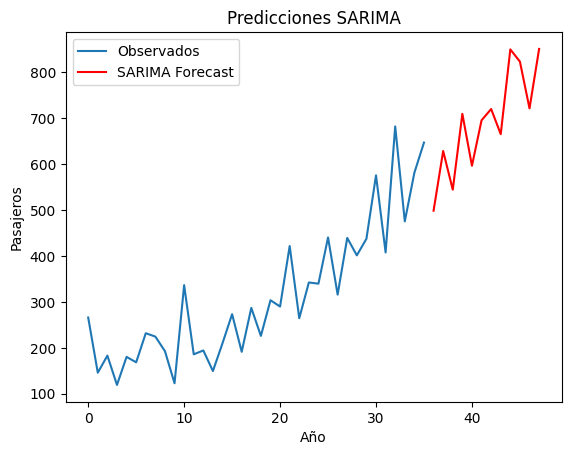

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

modelo = SARIMAX(df['Sales'], 
                 order = (1, 1, 1), 
                 seasonal_order=(1, 1, 1, 12))

# Ajustar (entrenar) el modelo SARIMA
modelo_ajustado = modelo.fit()

# Predicción
predicciones = modelo_ajustado.get_forecast(steps = 12).predicted_mean

# Graficar los df y las predicciones

df['Sales'].plot(label = 'Observados')
predicciones.plot(label = 'SARIMA Forecast', color = 'red')
plt.legend()
plt.title("Predicciones SARIMA")
plt.xlabel("Año")
plt.ylabel("Pasajeros")
plt.show()

### Prophet

In [ ]:
from prophet import Prophet

# Prophet requiere los df en un formato diferente

df = pd.read_csv('df/Sales.csv', header=0, index_col=None)
df['df']  = pd.to_datetime(df['Month'])
df[['y']] = df[['Sales']].astype(float)
df = df[["df","y"]]

modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative')

# Ajustar (entrenar) el modelo

modelo_ajustado = modelo.fit(df)

# Se requiere crear una serie con las fechas futuras

futuro = modelo_ajustado.make_future_dataframe(periodf = 48, freq = "ME")

# Hacer predicciones

predicciones = modelo_ajustado.predict(futuro)
predicciones[["df", "yhat", "yhat_lower", "yhat_upper"]].tail()

#  Graficar df y predicciones

modelo_ajustado.plot(predicciones)

# Graficar los componentes de la serie

modelo_ajustado.plot_components(predicciones)

## Comparación de algoritmos